# predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has private health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import utils
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import imblearn
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay

To predict which kind of insurance (if any) an individual has based on other attributes available in the census record, we can use supervised learning algorithms. Below we will try and compare logistic regression, a random forest model, and gradient boosting (xgboost).

In [2]:
# load pre-processed/scaled training data:
X_train  = pd.read_pickle('X_scaled_train.pkl')
y_train  = pd.read_pickle('y_train.pkl')

X_test  = pd.read_pickle('X_scaled_test.pkl')
y_test  = pd.read_pickle('y_test.pkl')
model_scores = {}

In [3]:
# name target variable
_,_,_,nsamples = utils.getVars()
datadir  = os.path.join(os.getcwd(),"small_data")

fname = os.path.join(datadir,str(nsamples) + 'targets_oi.csv')
targ_oi  = pd.read_csv(fname)
targname = targ_oi['healthcodes'][1]

details = utils.variableDetails(targname)
targlabels = details['values']['item'].values()

Using PCA below to reduce dimensions for numeric variables

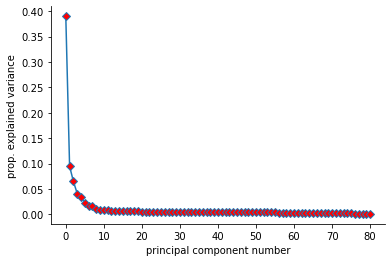

In [4]:
from sklearn.decomposition import PCA

num_train = X_train.select_dtypes('float')
num_test  = X_test.select_dtypes('float')

pc   = PCA().fit(num_train)

pc_train = pc.transform(num_train)
pc_test  = pc.transform(num_test)


plt.plot(pc.explained_variance_ratio_,marker='D',mfc='red')
sns.despine()
plt.ylabel('prop. explained variance')
plt.xlabel('principal component number')
plt.show()

# piece together categorical vars + first two principal components (from numerical columns)
pc_Xtrain = X_train.select_dtypes('uint8')
pc_Xtrain['pc_1'] = pc_train[:,0]
pc_Xtrain['pc_2'] = pc_train[:,1]

pc_Xtest= X_test.select_dtypes('uint8')
pc_Xtest['pc_1'] = pc_test[:,0]
pc_Xtest['pc_2'] = pc_test[:,1]

Write function that takes model object, a list of hyperparameters to tune, and train/test data. Fit, predict, score and save the model object.

In [5]:
def runModelandEvaluate(mdl,params,X_train,y_train,X_test,y_test):
    start_time = datetime.now()
    
    if mdl.__class__.__name__ == 'LogisticRegression':
        mdl_fname = mdl.__class__.__name__ + '_' + mdl.solver
    elif mdl.__class__.__name__ == 'DummyClassifier':
        mdl_fname = mdl.__class__.__name__ + '_' + mdl.strategy
    else:
        mdl_fname = mdl.__class__.__name__ 
    
    if os.path.exists(mdl_fname) == True:
        # open model object if already fit:
        mdl_cv = pd.read_pickle(mdl_fname)
        y_pred = mdl_cv.predict(X_test)
    else:
        if mdl.__class__.__name__ == 'DummyClassifier':
            mdl.fit(X_train,y_train)
            with open(mdl_fname, "wb") as f:
                pickle.dump(mdl, f)
            y_pred = mdl.predict(X_test)
        else:
            # or fit model
            mdl_cv  = GridSearchCV(mdl,params,cv=KFold(5),verbose=1,scoring='f1')
            mdl_cv.fit(X_train,y_train)
            with open(mdl_fname, "wb") as f:
                pickle.dump(mdl_cv, f)
            y_pred = mdl_cv.predict(X_test)

    delta_time = datetime.now()-start_time
    print(str(delta_time.seconds/60) + ' minutes')
    
    if mdl.__class__.__name__  == 'XGBClassifier':
        # flip positive and negative class to match neg/positive class of other models/this will make
        # comparing scores based on the positive class comparable
        y_pred = np.where(y_pred == 0,2,1)
        y_pred = np.where(y_pred==1,0,2)
        y_pred = np.where(y_pred==2,1,0)
        y_test = np.where(y_test== 0,2,1)
        y_test = np.where(y_test==1,0,2)
        y_test = np.where(y_test==2,1,0)
    
    disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,normalize='true')
    ac = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    pr = precision_score(y_test,y_pred,zero_division=0)
    re = recall_score(y_test,y_pred)
    model_scores[mdl_fname] = [ac,f1,pr,re]

In this case, we want to peform binary classification. Our target variable is categorical (private health insurance or not), and our predictors are both numeric and categorical variables.

First, we can fit a logistic regression model to the data, and see how well it can classify if someone has private health insurance. Since the data are strongly imbalanced, we can randomly under sample our majority sample (has private health insurance). For logistic regression, we also want to reduce dimensions where possible, so we can use the first two principal components of the numerical variables in place of all numeric variables. 

0.0 minutes


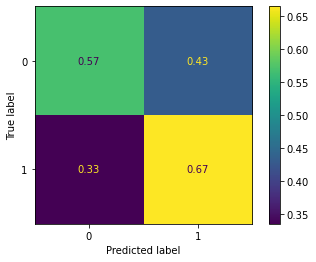

In [6]:
# logistic regression with random under-sampling
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()

X_train_rus,y_train_rus = rus.fit_resample(pc_Xtrain,y_train)

Cs     = [0.01, 0.1, 1, 10, 100]
params = {'C':Cs}
mdl = LogisticRegression(solver='liblinear')

runModelandEvaluate(mdl,params,X_train_rus,y_train_rus,pc_Xtest,y_test)

The second model we will fit for this binary classification problem is K-nearest neighbors. It makes sense again to use principal components to reduce dimensions, and to try to counteract the imbalanced data with random under sampling of the majority group.

0.0 minutes


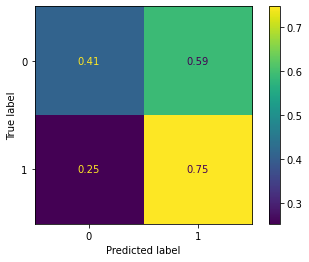

In [7]:
# knn
from sklearn.neighbors import KNeighborsClassifier

rus = RandomUnderSampler()

X_train_rus,y_train_rus = rus.fit_resample(pc_Xtrain,y_train)

params = {'n_neighbors':[2,3,4,5,6,7,8,9,10],'weights':['uniform','distance']}

mdl = KNeighborsClassifier()

runModelandEvaluate(mdl,params,X_train_rus,y_train_rus,pc_Xtest,y_test)

The third model we can fit for binary classification is a random forest model. In this case, we can use random under sampling again on the majority class to counteract the imbalanced data. For Random Forest models, we may want to use the numeric variables themselves instead of the top principal components from those variables because random forest models offer more interepratibility. If we use the PCs, we may lose useful information with respect to which features specifically are driving certain results.

0.0 minutes


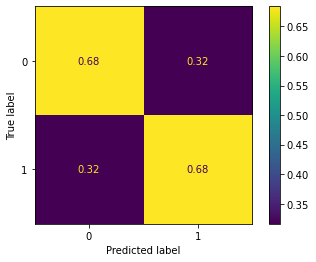

In [8]:
# random forest with random under-sampling
from sklearn.ensemble import RandomForestClassifier

rus = RandomUnderSampler()

X_train_rus,y_train_rus = rus.fit_resample(X_train,y_train)

params = {'n_estimators':[100,500,1000,1500], 
         'max_depth':[5, 10, 30, 50, None],
         'bootstrap':[True,False],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'max_features': ['auto', 'sqrt']}

mdl = RandomForestClassifier()

runModelandEvaluate(mdl,params,X_train_rus,y_train_rus,X_test,y_test)

The fourth model we will fit for this classification is an (extreme) gradient boosting model, with xgboost. This model is based on tree models, so again we can use the numeric variables themselves for interpretability. We also do not need to do random undersampling this time. Instead, we can tune a hyper-parameter (scale_pos_weight) that will 'weigh' the error term of the minority class more greatly so that these under-represented points are appropriately accounted for. 

0.0 minutes


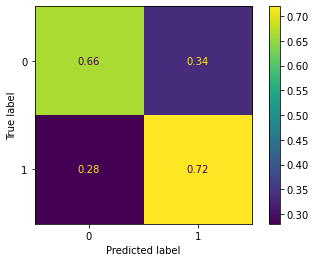

In [9]:
import xgboost as xgb

# for xgboost let's flip the values for the target variable (0-no private insurance: 1, 1-private insurance: 0)--so that the 
# majority class is set to 0 (the positive weight parameter will apply to the minority class--no private insurance)

y_train_xgb = y_train.replace({0:2,1:0,2:1})
y_test_xgb = y_test.replace({0:2,1:0,2:1})

# rule of thumb for scaling the minority class: 
guess_weight = round(sum(y_train_xgb == 0)/sum(y_train_xgb==1),0)

mdl = xgb.XGBClassifier(objective='binary:logistic')

params = {"learning_rate": [0.4, 0.2, 0.1],
              "subsample":[0.8,1.0],
    "scale_pos_weight": [guess_weight-1,guess_weight,guess_weight+1],
    "colsample_bytree":[0.7,1.0],
    'max_depth':[5, 10, 30, None],
}

runModelandEvaluate(mdl,params,X_train,y_train_xgb,X_test,y_test_xgb)

The fifth model we will fit for this binary classification is a support vector machine (SVM) model. Similar to KNN and logistic regression, we want to both reduce dimensions (use the PCs for numeric variables) and randomly under sample the majority class to counteract the imbalanced data.

0.016666666666666666 minutes


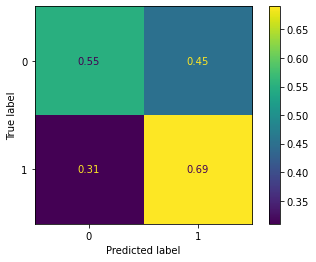

In [10]:
# svm
from sklearn.svm import SVC

rus = RandomUnderSampler()

X_train_rus,y_train_rus = rus.fit_resample(pc_Xtrain,y_train)

params = {'C': [0.1, 1, 10, 100],
        'gamma': [0.1,1,10, 100],
        'kernel': ['linear','rbf']}
 
mdl = SVC()

runModelandEvaluate(mdl,params,X_train_rus,y_train_rus,pc_Xtest,y_test)

Lastly, we'll run a dummy classifier. This model fit will serve us in evaluating the performance of the models above. How much better do our models perform over a classifer that does not take into account the training data?

0.0 minutes
0.0 minutes
0.0 minutes


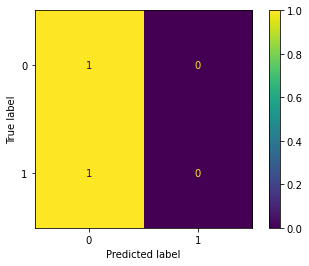

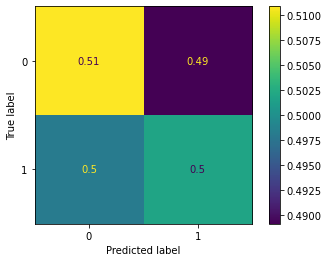

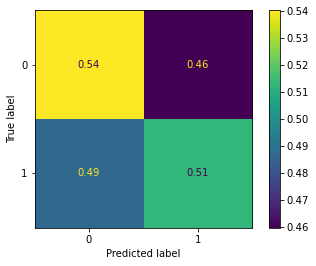

In [11]:
from sklearn.dummy import DummyClassifier


mdl = DummyClassifier(strategy="most_frequent")

runModelandEvaluate(mdl,[],X_train,y_train,pc_Xtest,y_test)

mdl = DummyClassifier(strategy="stratified")

runModelandEvaluate(mdl,[],X_train,y_train,pc_Xtest,y_test)

mdl = DummyClassifier(strategy="uniform")

runModelandEvaluate(mdl,[],X_train,y_train,pc_Xtest,y_test)

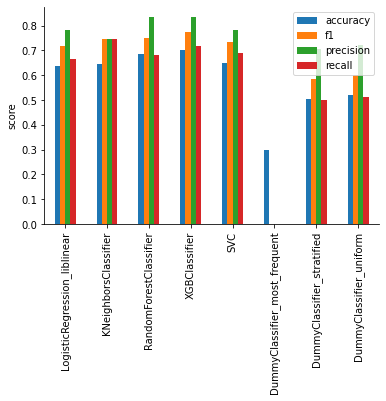

,accuracy,f1,precision,recall
XGBClassifier,0.702614,0.772044,0.832973,0.719421
RandomForestClassifier,0.683333,0.751220,0.834569,0.683007
KNeighborsClassifier,0.646078,0.747258,0.747084,0.747432
SVC,0.648366,0.733267,0.781712,0.690476
LogisticRegression_liblinear,0.636275,0.719152,0.782537,0.665266
DummyClassifier_uniform,0.521242,0.600055,0.722551,0.513072
DummyClassifier_stratified,0.504575,0.586470,0.705381,0.501867
DummyClassifier_most_frequent,0.300000,0.000000,0.000000,0.000000


In [12]:
scores = pd.DataFrame(model_scores).T
new_names = ['accuracy','f1','precision','recall']
cnt = 0
for i in new_names:
    scores.rename(columns={cnt:i},inplace=True)
    cnt += 1
scores.plot(kind='bar')
sns.despine()
plt.ylabel('score')
plt.show()

scores.sort_values('f1',ascending=False)

precision, tp/ (tp + fp): ability of classifier to identify true positives and keep out true negatives from pos class
recall, tp / (tp + fn): ability of classifier to find the positives
f1: mean of precision and recall, weigh keeping out true negs from positive class and finding positives equally

In this case, if we want to make sure that we do not miss an individual with private health insurance and we are okay with sometimes advertising to people who do not have private health insurance, we would want to priortize the recall score, find all the positives we can.

If we really did not want to advertise to anyone who does not already have private health insurance, we would want to priotize the precision score. 

If we want something in the middle, we can use the f1 score, which takes into account both of these goals. 

The extreme gradient boosting model is the best of those we tested if we want something in the middle (if we don't want to miss those with private insurance and we want to keep out those who do not have insurance), based on the f1 score. This model would also be good to use if we want to not advertise to those who do not have private health insurance (based on the precision score, though the Random Forest model performed equally well). 

If we wanted to make sure we didn't miss anyone with private health insurance already, we may want to use the KNN model because it outperformed the other models in terms of recall scores.

Note all models tested outperformed the best dummy classifiers.

In this case, the extreme gradient boosting model is our best bet. 